## Portfolio Optimization 

### (1) Importing libraries 

In [49]:
import yfinance as yf
import pandas as pd 
from datetime import datetime, timedelta
import numpy as np 
from scipy.optimize import minimize
import matplotlib.pyplot as plt


### Tickers and time

In [50]:
#tickers = ["SPY","BND","GLD","QQQ","VTI"]
tickers = ["AAPL", "JNJ", "XOM", "PG", "LMT"]

In [51]:
end_date = datetime.today()
# Just start date 5 years from current date
start_date = end_date - timedelta(days = 5*365)

### (2) Creating the Dataframe and getting adjusted close price 

In [52]:
adj_close_df = pd.DataFrame()

In [53]:
# Downloading the close price for each ticker
for ticker in tickers:
    data = yf.download(tickers=ticker,start = start_date, end=end_date)
    adj_close_df[ticker] = data["Adj Close"]  

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [54]:
print(adj_close_df)

                  AAPL         JNJ         XOM          PG         LMT
Date                                                                  
2019-11-22   63.447781  120.318192   54.430676  106.323257  341.892792
2019-11-25   64.560272  120.370796   54.069733  106.517715  341.227905
2019-11-26   64.056152  120.362015   53.936344  108.064537  343.432861
2019-11-27   64.916534  120.870964   53.904957  107.622566  344.955292
2019-11-29   64.773560  120.642799   53.457714  107.887733  344.242310
...                ...         ...         ...         ...         ...
2024-11-13  225.119995  153.240005  120.480003  166.580002  557.729980
2024-11-14  228.220001  151.869995  120.559998  167.080002  538.989990
2024-11-15  225.000000  154.000000  119.309998  169.539993  534.830017
2024-11-18  228.020004  154.770004  120.309998  170.750000  530.960022
2024-11-19  229.698105  152.669998  118.999901  170.880005  532.980103

[1256 rows x 5 columns]


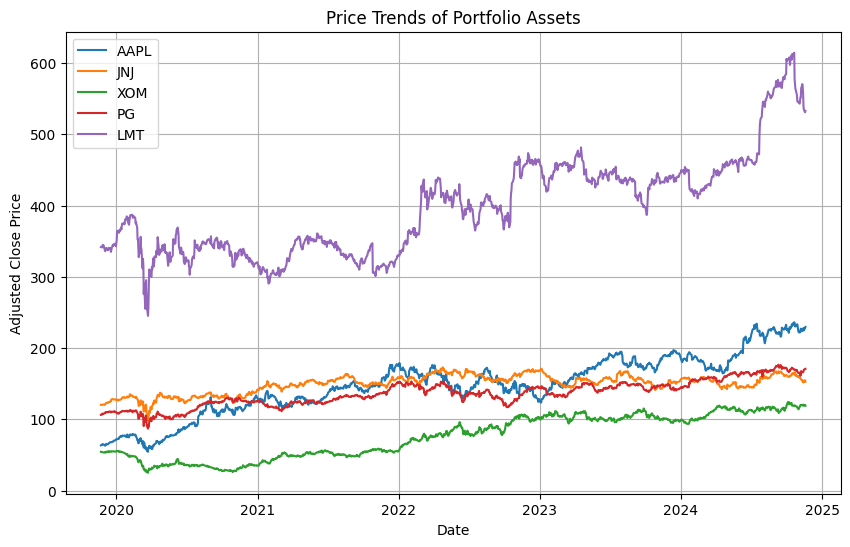

In [55]:
# Price Trends and Normalized Prices
# Price Trends Plot
plt.figure(figsize=(10, 6))
for ticker in tickers:
    plt.plot(adj_close_df[ticker], label=ticker)
plt.title('Price Trends of Portfolio Assets')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

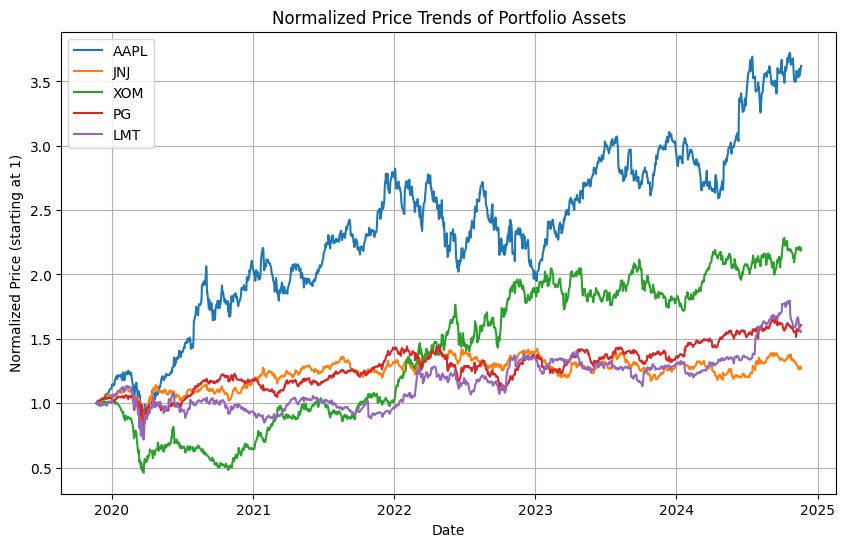

In [56]:
# Normalized Price Plot (all prices start at 1 for comparison)
normalized_prices = adj_close_df / adj_close_df.iloc[0]
plt.figure(figsize=(10, 6))
for ticker in tickers:
    plt.plot(normalized_prices[ticker], label=ticker)
plt.title('Normalized Price Trends of Portfolio Assets')
plt.xlabel('Date')
plt.ylabel('Normalized Price (starting at 1)')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

### (3) Calculating Lognormal returns Daily Returns

In [57]:
log_returns = np.log(adj_close_df/adj_close_df.shift(1))

In [58]:
# dropping missing values 
log_returns = log_returns.dropna()
print(log_returns)

                AAPL       JNJ       XOM        PG       LMT
Date                                                        
2019-11-25  0.017382  0.000437 -0.006653  0.001827 -0.001947
2019-11-26 -0.007839 -0.000073 -0.002470  0.014417  0.006441
2019-11-27  0.013342  0.004220 -0.000582 -0.004098  0.004423
2019-11-29 -0.002205 -0.001889 -0.008331  0.002461 -0.002069
2019-12-02 -0.011630 -0.000946  0.004247  0.005393 -0.019132
...              ...       ...       ...       ...       ...
2024-11-13  0.003961  0.003923  0.009263  0.004452 -0.014649
2024-11-14  0.013677 -0.008980  0.000664  0.002997 -0.034178
2024-11-15 -0.014210  0.013928 -0.010422  0.014616 -0.007748
2024-11-18  0.013333  0.004988  0.008347  0.007112 -0.007262
2024-11-19  0.007332 -0.013661 -0.010949  0.000761  0.003797

[1255 rows x 5 columns]


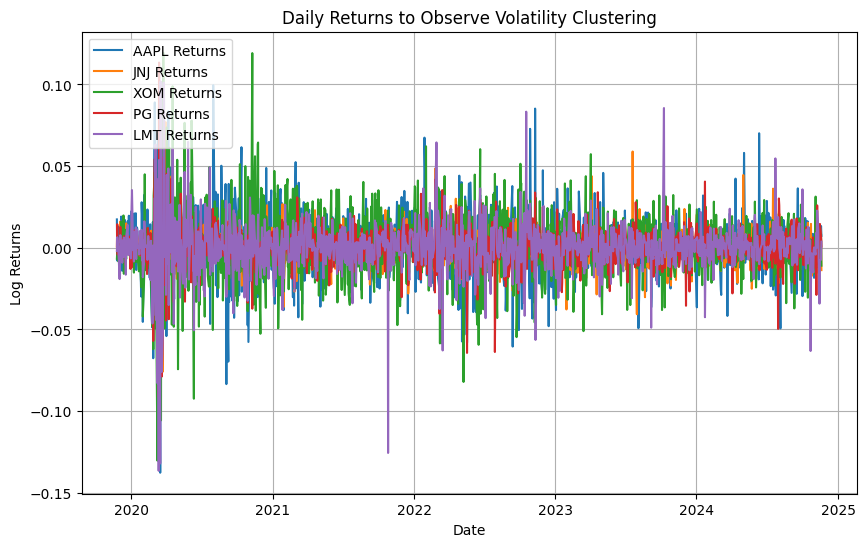

In [59]:
# Returns to Observe Volatility Clustering
plt.figure(figsize=(10, 6))
for ticker in tickers:
    plt.plot(log_returns[ticker], label=f'{ticker} Returns')
plt.title('Daily Returns to Observe Volatility Clustering')
plt.xlabel('Date')
plt.ylabel('Log Returns')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

### (4) Calcuating the Covariance Matrix

In [60]:
cov_matrix = log_returns.cov() * 252
print(cov_matrix)

          AAPL       JNJ       XOM        PG       LMT
AAPL  0.100559  0.023326  0.031602  0.028269  0.026738
JNJ   0.023326  0.038255  0.020114  0.025293  0.023016
XOM   0.031602  0.020114  0.118151  0.016331  0.037615
PG    0.028269  0.025293  0.016331  0.043567  0.024248
LMT   0.026738  0.023016  0.037615  0.024248  0.068322


### (5) Portfolio Perfomance metrics

#### Calculating Standard Deviation of the Portfolio

In [61]:
def standard_deviation(weights, cov_matrix):
    variance = weights.T@cov_matrix@weights
    return np.sqrt(variance)

#### Calculating expected return 

In [62]:
def expected_return(weights, log_returns): 
    return np.sum(log_returns.mean() * weights) * 252

#### Calculating the Sharpe Ratio

In [63]:
def sharpe_ratio(weights, log_returns,cov_matrix,risk_free_rate) :
    return (expected_return(weights,log_returns) - risk_free_rate) / standard_deviation(weights, cov_matrix)

### (6) Portfolio Optimization

#### Getting Risk Free Rate using the FED API 

In [64]:
from fredapi import Fred
fred = Fred(api_key = "d12e3b12f0540f09d785e8908b2d9aa9")
ten_year_treasury = fred.get_series_latest_release("GS10")/ 100

# setting the risk free rate 
risk_free_rate = ten_year_treasury.iloc[-1]
print(risk_free_rate)

0.040999999999999995


#### Minimizing the negative sharpe ratio

##### We minimize the -ve sharpe in order to 'MAXIMIZE the function' goal for a portfolio is a high sharpe ratio


In [65]:
def neg_sharpe_ratio(weights,log_returns,cov_matrix,risk_free_rate):
    return -sharpe_ratio(weights,log_returns,cov_matrix,risk_free_rate)

#### Next is setting up our constraints

##### Constraints are conditions that must be met during optimization, in this case the sum of all portfolio weights must be equal to 1. Bounds are limits placed.

In [66]:
constraints = {"type":"eq", "fun":lambda weights:np.sum(weights)-1}
bounds = [(0,0.5) for _ in range(len(tickers))]
# setting 0 as lower bound we can't short and 0.5 is we cannot have more than 50% weighting on an individual asset

#### Setting the initial weights

In [67]:
inital_weights = np.array([1/len(tickers)]*len(tickers))
print(inital_weights)

[0.2 0.2 0.2 0.2 0.2]


#### Optimize the weights to maximize the Sharpe Ratio

In [68]:
optimized_results = minimize(neg_sharpe_ratio,inital_weights,args=(log_returns,cov_matrix,risk_free_rate), 
                             method="SLSQP",constraints=constraints,bounds=bounds)
#SLSQP is Sequential Least Squares Quadratic Programing, numerical optimization suitable for non-linear optimization problems

#### Getting Optimal weights

In [69]:
optimal_weights = optimized_results.x

#### Displaying the Portfolio analystics 

In [70]:
print("Optimal weights")
for ticker,weight in zip(tickers,optimal_weights):
    print(f"{ticker}:{weight:.4f}")
print()

optimal_portfolio_return = expected_return(optimal_weights,log_returns)
optimal_portfolio_volatility = standard_deviation(optimal_weights,cov_matrix)
optimal_sharpe_ratio = sharpe_ratio(optimal_weights,log_returns,cov_matrix,risk_free_rate)

print(f"Expected Annual Return: {optimal_portfolio_return:.4f}")
print(f"Expected Volatility: {optimal_portfolio_volatility:.4f}")
print(f"Sharpe Ratio: {optimal_sharpe_ratio:.4f}")

Optimal weights
AAPL:0.5000
JNJ:0.0000
XOM:0.2586
PG:0.2414
LMT:0.0000

Expected Annual Return: 0.1928
Expected Volatility: 0.2294
Sharpe Ratio: 0.6617


### Final Plot

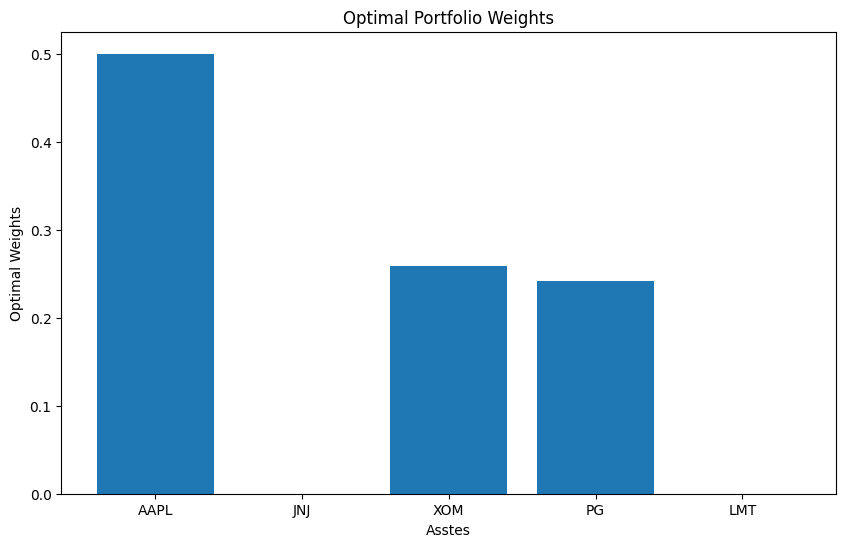

In [71]:
import matplotlib.pyplot as plt 
plt.figure(figsize=(10,6))
plt.bar(tickers,optimal_weights)

plt.xlabel("Asstes")
plt.ylabel("Optimal Weights")
plt.title("Optimal Portfolio Weights")

plt.show()

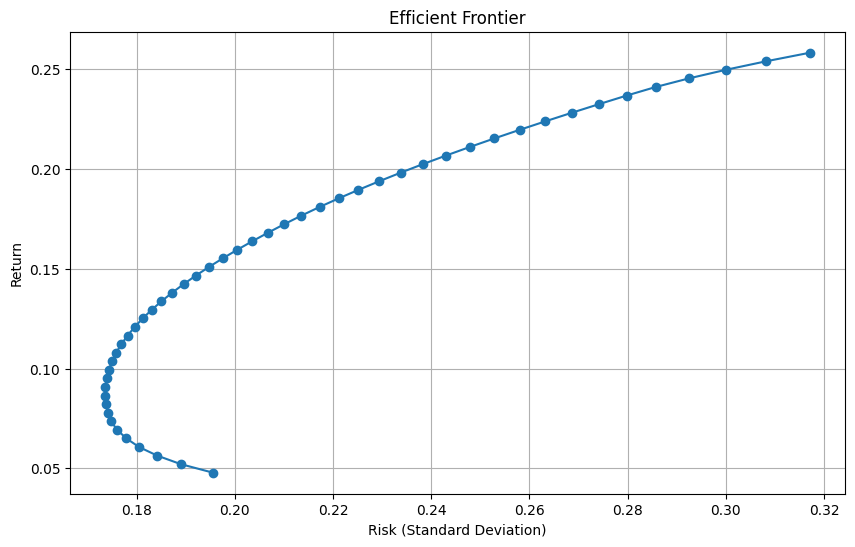

In [72]:
def portfolio_risk(weights, cov_matrix):
    return np.sqrt(weights.T @ cov_matrix @ weights)

def portfolio_return(weights, mean_returns):
    return np.sum(mean_returns * weights)

mean_returns = log_returns.mean() * 252  # Annualized mean returns
cov_matrix = log_returns.cov() * 252  # Annualized covariance matrix

target_returns = np.linspace(mean_returns.min(), mean_returns.max(), 50)
efficient_portfolios = []

for target_return in target_returns:
    constraints = (
        {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1},  # Weights sum to 1
        {'type': 'eq', 'fun': lambda weights: portfolio_return(weights, mean_returns) - target_return}  # Return target
    )
    bounds = [(0, 1) for _ in range(len(tickers))]
    result = minimize(portfolio_risk, inital_weights, args=(cov_matrix,), method='SLSQP', bounds=bounds, constraints=constraints)
    efficient_portfolios.append((portfolio_risk(result.x, cov_matrix), target_return))

efficient_portfolios_df = pd.DataFrame(efficient_portfolios, columns=['Risk', 'Return'])

plt.figure(figsize=(10, 6))
plt.plot(efficient_portfolios_df['Risk'], efficient_portfolios_df['Return'], marker='o')
plt.title('Efficient Frontier')
plt.xlabel('Risk (Standard Deviation)')
plt.ylabel('Return')
plt.grid(True)
plt.show()